In [1]:
!pip install sagemaker boto3 torchvision scikit-learn

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA available?:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

PyTorch version: 2.2.2
Is CUDA available?: True
CUDA version: 12.1
Device name: Tesla T4


In [4]:
import os
import boto3
import torch
import numpy as np
import shutil  
import random
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [5]:
!pip install imbalanced-learn

In [6]:
!pip install opencv-python

In [7]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # 또는 ":16:8"
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

seed_everything(42) # Seed 고정

In [8]:
# 1. S3 데이터 다운로드 및 준비
import os
import boto3

# S3 데이터 다운로드 함수
def download_from_s3(bucket_name, prefix, local_dir):
    """
    S3에서 데이터를 가져와서 지정된 로컬 디렉토리에 저장
    """
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    total_files = 0  # 총 다운로드된 파일 수를 확인하기 위한 변수

    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            local_path = os.path.join(local_dir, os.path.relpath(key, prefix))
            os.makedirs(os.path.dirname(local_path), exist_ok=True)

            # 파일 다운로드
            if not os.path.exists(local_path):
                print(f"Downloading {key} to {local_path}")
                s3.download_file(bucket_name, key, local_path)
                total_files += 1  # 다운로드된 파일 수 증가

    print(f"S3 데이터 다운로드 총 다운로드된 파일 수: {total_files}")
    return total_files

# S3 버킷 정보
bucket_name = "smwu-cv-data"
prefix = "data/다이캐스팅/g2/"
local_dir = "./data"

# S3에서 데이터 다운로드
total_downloaded_files = download_from_s3(bucket_name, prefix, local_dir)
print(f"총 다운로드된 파일 수: {total_downloaded_files}")

S3 데이터 다운로드 총 다운로드된 파일 수: 0
총 다운로드된 파일 수: 0


In [10]:
import os

# 다운로드된 파일 개수 
def count_downloaded_files(directory):
    """
    지정된 디렉토리 내의 모든 파일 개수를 반환
    """
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# S3에서 다운로드 후 데이터 개수 확인
total_downloaded = count_downloaded_files(local_dir)
print(f"총 다운로드된 파일 수: {total_downloaded}")

총 다운로드된 파일 수: 1917


In [9]:
import os
import shutil

def organize_images(base_dir, new_base_dir):
    """
    기존 g2 폴더에 있는 데이터셋에서 NG와 OK 이미지를 별도로 분류하여 data_diecasting 새로운 폴더에 복사
    """
    os.makedirs(os.path.join(new_base_dir, "NG"), exist_ok=True)
    os.makedirs(os.path.join(new_base_dir, "OK"), exist_ok=True)

    ng_count, ok_count = 0, 0  # NG와 OK 파일 수를 계산하기 위한 변수

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                src_path = os.path.join(root, file)
                # 고유 파일 이름 생성
                unique_file_name = f"{os.path.basename(root)}_{file}"
                
                if "NG" in root:
                    # 중복 파일  -> 복사할 때 파일 이름이 중복되지 않도록 
                    dst_path = os.path.join(new_base_dir, "NG", unique_file_name)
                    shutil.copy(src_path, dst_path)
                    ng_count += 1
                elif "OK" in root:
                    dst_path = os.path.join(new_base_dir, "OK", unique_file_name)
                    shutil.copy(src_path, dst_path)
                    ok_count += 1

    print(f"데이터 구조 NG: {ng_count}개, OK: {ok_count}개")
    return ng_count, ok_count

# 데이터 정리 실행
new_base_dir = "./data_diecasting"
ng_count, ok_count = organize_images(local_dir, new_base_dir)
print(f"NG 데이터 개수: {ng_count}")
print(f"OK 데이터 개수: {ok_count}")

데이터 구조 NG: 825개, OK: 1077개
NG 데이터 개수: 825
OK 데이터 개수: 1077


In [ ]:
#[기존 데이터셋 구조]

# data/
#     dataset_2023-10-17/
#         NG/
#             1/
#                 image1.jpg
#                 image2.jpg
#             2/
#                 image3.jpg
#         OK/
#             1/
#                 image4.jpg
#                 image5.jpg
#     dataset_2024-01-15/
#         ...

In [ ]:
# [데이터셋 구조 재정의] 
# base_dir/
#     NG/
#         dataset_2023-10-17/NG/1/image1.png
#         dataset_2024-01-15/NG/2/image2.png
#     OK/
#         dataset_2023-10-17/OK/1/image3.png
#         dataset_2024-01-30/OK/3/image4.png

# data_diecasting/
#     NG/
#         image1.jpg
#         image2.jpg
#         ...
#     OK/
#         image1.jpg
#         image2.jpg
#         ...

In [11]:
# NG와 OK 폴더에 있는 실제 파일 수 확인
def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

ng_actual_count = count_files_in_folder(os.path.join(new_base_dir, "NG"))
ok_actual_count = count_files_in_folder(os.path.join(new_base_dir, "OK"))

print(f"NG 폴더 내 실제 데이터 개수: {ng_actual_count}")
print(f"OK 폴더 내 실제 데이터 개수: {ok_actual_count}")

NG 폴더 내 실제 데이터 개수: 825
OK 폴더 내 실제 데이터 개수: 1077


In [12]:
# 정리된 데이터 디렉토리
dataset = datasets.ImageFolder(new_base_dir)

# 데이터 개수 및 클래스 확인
print(f"Class to Index Mapping: {dataset.class_to_idx}")  # {'NG': 0, 'OK': 1}로 출력 
print(f"Total Images: {len(dataset)}")

Class to Index Mapping: {'NG': 0, 'OK': 1}
Total Images: 1902


In [13]:
import cv2
from torch.utils.data import random_split
from imblearn.over_sampling import SMOTE
import numpy as np
from tqdm import tqdm
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset
from PIL import Image

# 데이터셋 분리
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)



# 이전 ) Resize and Pad 이미지 처리 함수
# def resize_and_pad_image(img, target_size=(224, 224)):
#     img = np.array(ToPILImage()(img))  # 텐서를 PIL -> Numpy 배열로 변환
#     h, w = img.shape[:2]
#     scale = min(target_size[0] / w, target_size[1] / h)
#     new_w, new_h = int(w * scale), int(h * scale)
#     resized_img = cv2.resize(img, (new_w, new_h))

#     top_pad = (target_size[1] - new_h) // 2
#     bottom_pad = target_size[1] - new_h - top_pad
#     left_pad = (target_size[0] - new_w) // 2
#     right_pad = target_size[0] - new_w - left_pad

#     padded_img = cv2.copyMakeBorder(resized_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#     return padded_img.astype(np.uint8)

# 수정 Resize and Pad 이미지 처리 함수 
def resize_and_pad_image(img, target_size=(240, 240)):
    if isinstance(img, Image.Image):
        img = np.array(img)
    h, w = img.shape[:2]
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized_img = cv2.resize(img, (new_w, new_h))

    top_pad = (target_size[1] - new_h) // 2
    bottom_pad = target_size[1] - new_h - top_pad
    left_pad = (target_size[0] - new_w) // 2
    right_pad = target_size[0] - new_w - left_pad

    padded_img = cv2.copyMakeBorder(resized_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img.astype(np.uint8)


# Train 데이터 추출
train_images, train_labels = [], []
for img, label in tqdm(train_dataset, desc="Extracting Train Dataset"):
    img = resize_and_pad_image(img)
    train_images.append(img)
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# SMOTE 적용
n_samples, height, width, channels = train_images.shape
train_images_reshaped = train_images.reshape(n_samples, -1)  # SMOTE는 2D 배열을 입력으로 받음
smote = SMOTE(sampling_strategy='minority', random_state=42)
images_resampled, labels_resampled = smote.fit_resample(train_images_reshaped, train_labels)

# Reshaped 데이터를 원래 형태로 변환
images_resampled = images_resampled.reshape(-1, height, width, channels)

print(f"Original Train Dataset NG: {sum(train_labels == 0)}, OK: {sum(train_labels == 1)}")
print(f"Resampled Train Dataset NG: {sum(labels_resampled == 0)}, OK: {sum(labels_resampled == 1)}")

Extracting Train Dataset: 100%|██████████| 1521/1521 [01:11<00:00, 21.24it/s]


Original Train Dataset NG: 653, OK: 868
Resampled Train Dataset NG: 868, OK: 868


In [14]:
# CustomDataset 정의
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# SMOTE 데이터셋 생성
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_smote = CustomDataset(images_resampled, labels_resampled, transform=train_transform)

# 검증 및 테스트 데이터셋 변환
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_images, val_labels = zip(*[(resize_and_pad_image(img), label) for img, label in val_dataset])
test_images, test_labels = zip(*[(resize_and_pad_image(img), label) for img, label in test_dataset])

val_dataset = CustomDataset(val_images, val_labels, transform=val_test_transform)
test_dataset = CustomDataset(test_images, test_labels, transform=val_test_transform)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset_smote, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Dataset: {len(train_loader.dataset)}")
print(f"Validation Dataset: {len(val_loader.dataset)}")
print(f"Test Dataset: {len(test_loader.dataset)}")

Train Dataset: 1736
Validation Dataset: 190
Test Dataset: 191


In [15]:
%%writefile model_definition.py
import torch.nn as nn
#from torchvision.models import efficientnet_b0
from torchvision.models import efficientnet_b1

class BaseModel(nn.Module):
    def __init__(self, num_classes=2):
        super(BaseModel, self).__init__()
        # EfficientNet-b1 백본 사용
        self.backbone = efficientnet_b1(pretrained=True)
        # 분류기를 num_classes에 맞게 수정
        self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

print("model_definition.py 파일로 저장되었습니다.")

Writing model_definition.py


In [16]:

# Training 함수
def train(model, optimizer, train_loader, val_loader, scheduler, device, patience=5, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    # Early Stopping 관련 변수
    best_accuracy = 0
    best_model_state = None
    no_improvement_epochs = 0

    # 손실 및 정확도 기록
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = []
        train_correct = 0
        train_total = 0

        # Training Loop
        for img, label in tqdm(iter(train_loader), desc=f"Epoch {epoch}/{epochs}"):
            img, label = img.to(device).float(), label.to(device)

            optimizer.zero_grad()
            model_pred = model(img)
            loss = criterion(model_pred, label)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            # Accuracy 계산
            _, preds = torch.max(model_pred, 1)
            train_correct += (preds == label).sum().item()
            train_total += label.size(0)

        # Training 결과 기록
        train_loss_mean = sum(train_loss) / len(train_loss)
        train_losses.append(train_loss_mean)
        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        # Validation
        val_loss, val_accuracy = validation(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch}: Train Loss: {train_loss_mean:.5f}, Train Accuracy: {train_accuracy:.5f}, "
              f"Val Loss: {val_loss:.5f}, Val Accuracy: {val_accuracy:.5f}")

        # Scheduler 업데이트
        if scheduler is not None:
            scheduler.step(val_loss)

        # Best Model 저장
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        # Early Stopping 체크
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Accuracy: {best_accuracy:.5f}")
            break

    # Best Model 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Loss와 Accuracy 그래프 시각화
    plt.figure(figsize=(14, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [17]:
# Validation 함수
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(iter(val_loader), desc="Validation"):
            img, label = img.to(device).float(), label.to(device)
            model_pred = model(img)
            loss = criterion(model_pred, label)
            val_loss.append(loss.item())

            # Accuracy 계산
            _, preds = torch.max(model_pred, 1)
            correct += (preds == label).sum().item()
            total += label.size(0)

    val_loss_mean = sum(val_loss) / len(val_loss)
    val_accuracy = correct / total
    return val_loss_mean, val_accuracy


model_definition.py 파일로 저장되었습니다.


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


Epoch 1: Train Loss: 0.48942, Train Accuracy: 0.74309, Val Loss: 0.49604, Val Accuracy: 0.79474


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.78it/s]


Epoch 2: Train Loss: 0.24944, Train Accuracy: 0.89862, Val Loss: 0.18011, Val Accuracy: 0.94211


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.79it/s]


Epoch 3: Train Loss: 0.16960, Train Accuracy: 0.94009, Val Loss: 0.11316, Val Accuracy: 0.96842


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.84it/s]


Epoch 4: Train Loss: 0.15814, Train Accuracy: 0.94873, Val Loss: 0.13060, Val Accuracy: 0.95789


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.97it/s]


Epoch 5: Train Loss: 0.12313, Train Accuracy: 0.96313, Val Loss: 0.07846, Val Accuracy: 0.98947


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.80it/s]


Epoch 6: Train Loss: 0.10608, Train Accuracy: 0.96774, Val Loss: 0.20099, Val Accuracy: 0.95263


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.92it/s]


Epoch 7: Train Loss: 0.08990, Train Accuracy: 0.97408, Val Loss: 0.08136, Val Accuracy: 0.98421


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.83it/s]


Epoch 8: Train Loss: 0.09452, Train Accuracy: 0.96544, Val Loss: 0.09735, Val Accuracy: 0.96842


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.85it/s]


Epoch 9: Train Loss: 0.10801, Train Accuracy: 0.96659, Val Loss: 0.08652, Val Accuracy: 0.98947


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.98it/s]


Epoch 10: Train Loss: 0.06189, Train Accuracy: 0.98041, Val Loss: 0.08251, Val Accuracy: 0.98947
Early stopping triggered at epoch 10. Best Val Accuracy: 0.98947


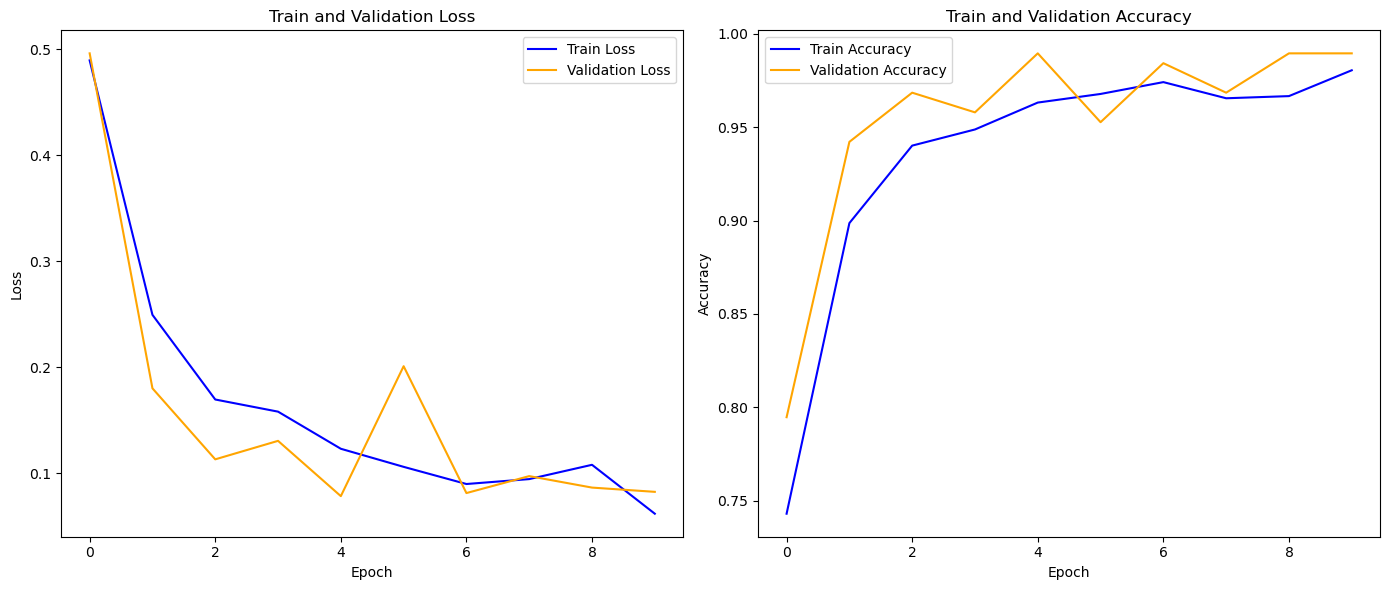

Model weights saved as 'model_weights.pth'


In [18]:
from torchvision.models import efficientnet_b1
from model_definition import BaseModel
from sklearn.metrics import accuracy_score   
import time  
from sklearn.metrics import classification_report  

# Inference 함수
def inference(model, test_loader, device):
    model.to(device)
    model.eval()

    model_preds = []
    model_probs = []
    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for img, _ in tqdm(iter(test_loader), desc="Inference"):
            batch_size = img.size(0)
            img = img.float().to(device)
            total_images += batch_size

            start_time = time.time()

            # 모델 예측
            model_pred = model(img)
            probabilities = torch.softmax(model_pred, dim=1)

            end_time = time.time()
            total_time += (end_time - start_time)

            # 예측 저장
            model_preds.extend(model_pred.argmax(1).detach().cpu().numpy().tolist())
            model_probs.extend(probabilities.detach().cpu().numpy().tolist())

    avg_inference_time = total_time / total_images
    print(f"Average Inference Time per Image: {avg_inference_time:.4f} seconds")

    return model_preds, model_probs

# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseModel(num_classes=2).to(device)

# Optimizer와 Scheduler 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 모델 학습
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device, patience=5, epochs=50)

# 학습된 모델 저장
# 모델 전체 저장
# torch.save(best_model, "model.pth")

#가중치만 저장
torch.save(best_model.state_dict(), "model_weights.pth")
print("Model weights saved as 'model_weights.pth'")

In [19]:
# Inference 실행
preds, probs = inference(best_model, test_loader, device)

Inference: 100%|██████████| 6/6 [00:00<00:00, 11.89it/s]

Average Inference Time per Image: 0.0007 seconds


In [20]:
from sklearn.metrics import accuracy_score  # 추가

# Test Accuracy 계산
true_labels = [label for _, label in test_dataset]
accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.95%


In [21]:
# 성능 지표 출력
print(classification_report(true_labels, preds, target_names=['NG', 'OK']))

              precision    recall  f1-score   support

          NG       0.99      0.99      0.99        87
          OK       0.99      0.99      0.99       104

    accuracy                           0.99       191
   macro avg       0.99      0.99      0.99       191
weighted avg       0.99      0.99      0.99       191



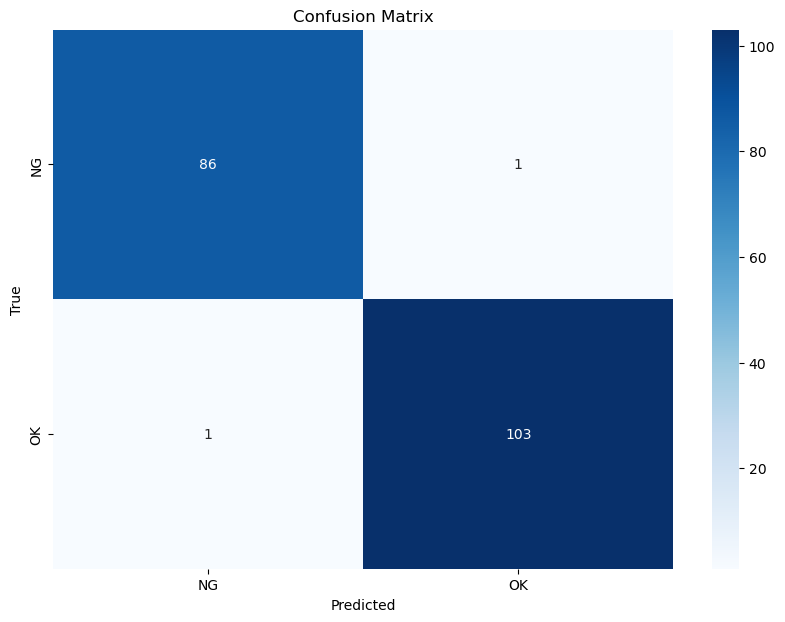

In [22]:
from sklearn.metrics import confusion_matrix  # confusion_matrix 추가
import seaborn as sns  # Seaborn 추가
import matplotlib.pyplot as plt  # Matplotlib 추가


# Confusion Matrix 시각화
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NG', 'OK'], yticklabels=['NG', 'OK'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 전처리 파이프라인 정의 (val_test_transforms)
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# GradCam 클래스 정의
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to capture gradients and activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        target = output[0, class_idx]
        target.backward()

        # Compute GradCam heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam = (weights * self.activations).sum(dim=1, keepdim=True)
        gradcam = F.relu(gradcam)
        gradcam = F.interpolate(gradcam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)
        gradcam = gradcam.squeeze().cpu().numpy()
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize to [0, 1]
        return gradcam


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1..1.0].


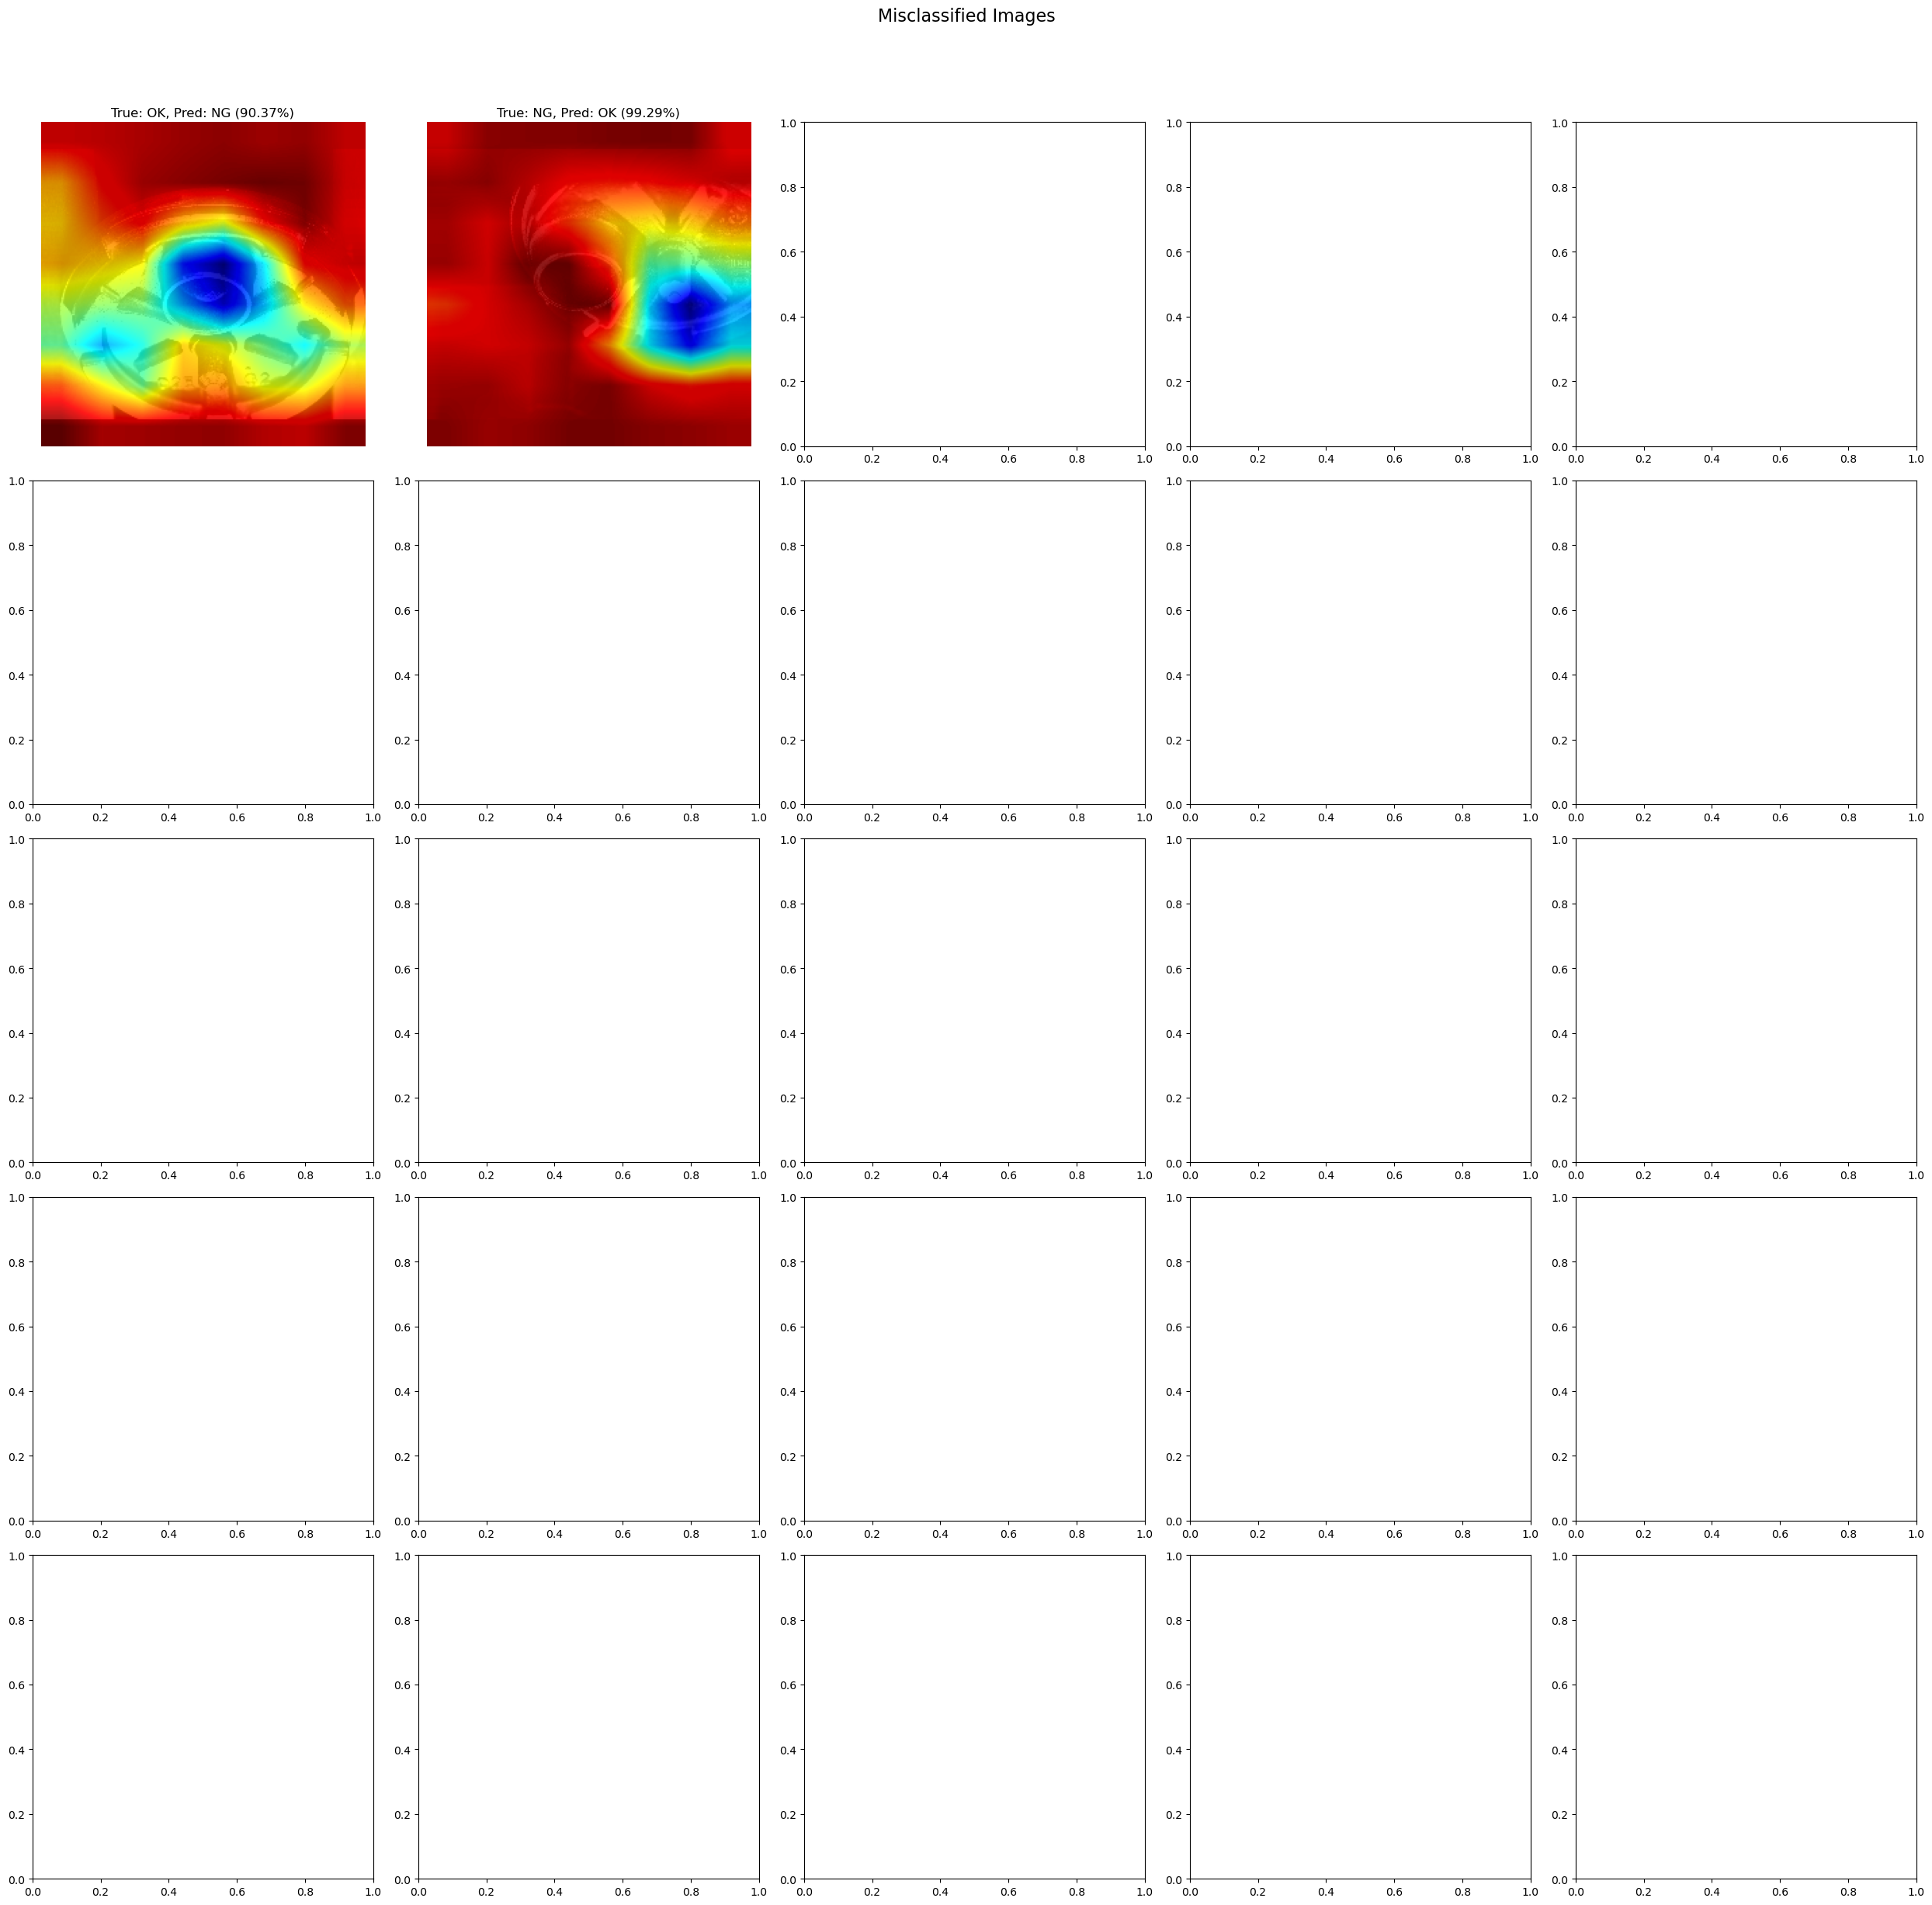

In [24]:

# 잘못 분류된 인덱스 찾기
misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != preds[i]]
classes = ['NG', 'OK']

# GradCam 생성
gradcam = GradCam(model, target_layer=model.backbone.features[-1])

# 잘못 분류된 이미지 시각화
if len(misclassified_indices) > 0:
    fig, axes = plt.subplots(5, 5, figsize=(25, 25))
    fig.suptitle('Misclassified Images', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= len(misclassified_indices):
            break
        idx = misclassified_indices[i]
        img, true_label = test_dataset[idx]  # 테스트 데이터에서 이미지와 라벨 가져오기

        # 전처리 적용 및 배치 차원 추가
        img_tensor = val_test_transforms(img).unsqueeze(0).to(device)
        heatmap = gradcam(img_tensor)  # GradCam 결과 생성

        # 시각화를 위해 numpy 형태로 변환
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = heatmap.astype(np.float32) / 255.0  # 정규화

        # 원본 이미지와 heatmap 합성
        overlay = cv2.addWeighted(img, 0.1, heatmap, 0.9, 0)

        pred_label = preds[idx]  # 예측 라벨
        pred_prob = probs[idx][pred_label] * 100  # 예측 확률

        # 결과 시각화
        ax.imshow(overlay)
        ax.axis('off')
        ax.set_title(f'True: {classes[true_label]}, Pred: {classes[pred_label]} ({pred_prob:.2f}%)', color='black')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No misclassified images found.")

In [30]:
%%writefile inference.py
import time
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from PIL import Image
import json
import io
from model_definition import BaseModel  # BaseModel 가져오기

# 모델 로드 함수
def model_fn(model_dir):
    model_path = f"{model_dir}/model_weights.pth"  # 가중치 파일 경로를 명확히 지정
    print(f"Loading weights from: {model_path}")

    try:
        model = BaseModel(num_classes=2)  # BaseModel 초기화
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(state_dict, strict=False)  # strict=False로 유연하게 로드
        model.eval()  # 평가 모드로 전환
        print("Model and weights loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e

    return model

# 입력 데이터 처리
def input_fn(request_body, request_content_type):
    if request_content_type == 'application/x-image':
        image = Image.open(io.BytesIO(request_body))
        if image.mode != 'RGB':
            image = image.convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((240, 240)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        return transform(image).unsqueeze(0)
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

# 예측 수행
def predict_fn(input_data, model):
    import time
    start_time = time.time()
    with torch.no_grad():
        output = model(input_data)
    end_time = time.time()
    print(f"Inference Time: {end_time - start_time:.4f} seconds")
    _, predicted = torch.max(output, 1)
    return predicted.item()


# 출력 데이터 처리
def output_fn(prediction, response_content_type):
    return json.dumps({'predicted_class': prediction})

Overwriting inference.py


In [31]:
import torch
model_path = "model_weights.pth"
try:
    model = torch.load(model_path, map_location=torch.device('cpu'))
    print(f"Loaded model type: {type(model)}")
except Exception as e:
    print(f"Error loading model: {e}")

Loaded model type: <class 'collections.OrderedDict'>


In [35]:
# 배포 전 로컬에서 미리 예측 테스트 
import boto3
from PIL import Image
from inference import model_fn , predict_fn

# 모델 로드
model_dir = "."
print(f"Model directory: {model_dir}")

model = model_fn(model_dir)


# S3에서 이미지 다운로드
s3 = boto3.client("s3")
bucket_name = "smwu-cv-data"
# key = "data/다이캐스팅/g2/dataset_2024-01-30/OK/1/20240130-123832525.png"
key = "data/다이캐스팅/g2/dataset_2024-01-15/OK/1/20231214-120131084.png"
# key = "data/다이캐스팅/g2/dataset_2024-01-15/NG/1/20231214-113811300.png"


local_file_path = "/tmp/test_image.png"

print(f"Downloading {key} from S3 bucket {bucket_name}...")
s3.download_file(bucket_name, key, local_file_path)
print(f"Image downloaded to {local_file_path}")

# 모델 로드
model_dir = "."
model = model_fn(model_dir)

# 이미지 로드 및 전처리
image = Image.open(local_file_path)
if image.mode != "RGB":
    image = image.convert("RGB")
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_data = transform(image).unsqueeze(0)

# 예측 수행
prediction = predict_fn(input_data, model)
print(f"Predicted class: {prediction}")

Model directory: .
Loading weights from: ./model_weights.pth
Model and weights loaded successfully
Image downloaded to /tmp/test_image.png
Loading weights from: ./model_weights.pth
Model and weights loaded successfully
Inference Time: 0.0435 seconds
Predicted class: 1


In [50]:
# 로컬에서 테스트 
from PIL import Image
from inference import model_fn, predict_fn
import torch
import torchvision.transforms as transforms

# 모델 로드
model = model_fn(".")  # 현재 디렉토리에 있는 모델 로드

# 테스트 이미지 로드
image_path = "test_image.png"
image = Image.open(image_path)

# 이미지 RGB 변환
if image.mode != "RGB":
    image = image.convert("RGB")

# 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),  # 단일 채널 이미지를 3채널로 확장
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 전처리 적용
input_data = transform(image).unsqueeze(0)

# 모델 예측 수행
prediction = predict_fn(input_data, model)

# 예측 결과 출력
print(f"Predicted class: {prediction}")

Loading weights from: ./model_weights.pth
Model and weights loaded successfully
Inference Time: 0.0427 seconds
Predicted class: 0


In [39]:
import tarfile

# 압축 파일 이름 설정
output_file = "model.tar.gz"

# 압축 파일 생성
with tarfile.open(output_file, "w:gz") as tar:
    tar.add("model_weights.pth", arcname="model_weights.pth")  # 모델 파일 추가
    tar.add("inference.py", arcname="inference.py")  # 추론 코드 추가
    tar.add("model_definition.py", arcname="model_definition.py")  # 모델 정의 코드 추가
print(f"압축: {output_file}")

압축: model.tar.gz


In [40]:
import boto3

# S3 업로드
s3 = boto3.client("s3")
bucket_name = "cv-diecasting-model"  # S3 버킷 이름
model_key = "models/efficientnet/model.tar.gz"  # 업로드 경로

s3.upload_file("model.tar.gz", bucket_name, model_key)
print(f"Model uploaded to s3://{bucket_name}/{model_key}")

Model uploaded to s3://cv-diecasting-model/models/efficientnet/model.tar.gz


In [42]:
import boto3
import os

# S3 모델 경로 (환경 변수에서 불러오기)
bucket_name = os.getenv("S3_BUCKET_NAME")  # 환경 변수로 설정: S3_BUCKET_NAME
model_key = os.getenv("MODEL_KEY")        # 환경 변수로 설정: MODEL_KEY
model_s3_uri = f"s3://{bucket_name}/{model_key}"

# 컨테이너 이미지 (AWS 공식 컨테이너 이미지 사용)
container_image = (
    "763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:2.2.0-gpu-py310-cu118-ubuntu20.04-sagemaker"
)

# SageMaker 모델 이름 및 역할 (환경 변수에서 불러오기)
model_name = os.getenv("MODEL_NAME", "diecasting-model-T7")  # 기본값 설정
role = os.getenv("SAGEMAKER_ROLE_ARN")  # 환경 변수로 설정: SAGEMAKER_ROLE_ARN

# SageMaker 모델 생성
sm_client = boto3.client("sagemaker")
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        "Image": container_image,
        "ModelDataUrl": model_s3_uri,
        "Environment": {
            "SAGEMAKER_PROGRAM": "inference.py",  # 사용자 제공 스크립트
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "us-west-2",  # SageMaker 배포 리전
        },
    },
    ExecutionRoleArn=role,
)

print(f"Model {model_name} created successfully!")

Model diecasting-model-T7 created successfully!


In [43]:
from sagemaker.model import Model

# 엔드포인트 설정
endpoint_name = "diecasting-model-T7-endpoint"

# SageMaker 세션과 역할 지정
role = os.getenv("SAGEMAKER_ROLE_ARN") 
# SageMaker 모델
model = Model(
    model_data=model_s3_uri,
    image_uri=container_image,
    role=role,
    name=model_name,
)

# 엔드포인트 배포
predictor = model.deploy(
    initial_instance_count=1,  # 엔드포인트 인스턴스 개수
    instance_type="ml.g4dn.xlarge",  # 엔드포인트 인스턴스 유형
    endpoint_name=endpoint_name,
)

print(f"Endpoint {endpoint_name} deployed successfully!")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Using already existing model: diecasting-model-T7


------------!Endpoint diecasting-model-T7-endpoint deployed successfully!


In [47]:
import boto3
import json

# 엔드포인트 이름
runtime = boto3.client("sagemaker-runtime")
endpoint_name = "diecasting-model-T7-endpoint"

# 테스트 이미지 
with open("/tmp/test_image.png", "rb") as f:
    payload = f.read()

# 추론 요청
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/x-image",  # 요청 타입
    Body=payload,
)

# 응답 출력
result = json.loads(response["Body"].read().decode())
print(f"Predicted class: {result['predicted_class']}")

Predicted class: 1
